# Enhancing Customer Experiences through Deep Learning-Powered Sentiment Analysis of Reviews

# LTSM Model

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import BertTokenizer

In [3]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, sentiments, labels, tokenizer, max_len):
        self.texts = texts
        self.sentiments = sentiments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment = str(self.sentiments[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'sentiment': sentiment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Use the last hidden state
        return out

In [32]:
# Load the dataset from CSV
df = pd.read_csv('Data.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:


# Assuming the CSV file has 'textID', 'text', 'selected_text', and 'sentiment' columns
texts = df['text'].values
sentiments = df['sentiment'].values
labels = df['selected_text'].values

# Tokenize and encode the texts using a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 100  # maximum sequence length

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create DataLoader for train and test sets
train_dataset = CustomDataset(X_train, sentiments, y_train, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(X_test, sentiments, y_test, tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Initialize the LSTM model
input_dim = len(tokenizer)
hidden_dim = 128
output_dim = len(label_encoder.classes_)
model = LSTMModel(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses = []  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()

        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # save the loss for plotting
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")




Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:56<00:00,  3.88it/s]


Epoch 1/10, Loss: 10.024290501290533


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:58<00:00,  3.85it/s]


Epoch 2/10, Loss: 9.846060432200868


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:20<00:00,  4.89it/s]


Epoch 3/10, Loss: 9.62644138225128


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:18<00:00,  4.95it/s]


Epoch 4/10, Loss: 9.55471216643221


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:23<00:00,  4.79it/s]


Epoch 5/10, Loss: 9.528275660552312


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:23<00:00,  4.79it/s]


Epoch 6/10, Loss: 9.515258905668967


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:34<00:00,  4.46it/s]


Epoch 7/10, Loss: 9.506842159287899


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [19:43<00:00,  1.72s/it]


Epoch 8/10, Loss: 9.501295624167986


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:10<00:00,  5.27it/s]


Epoch 9/10, Loss: 9.497305042705507


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 687/687 [02:11<00:00,  5.21it/s]

Epoch 10/10, Loss: 9.494349966923743


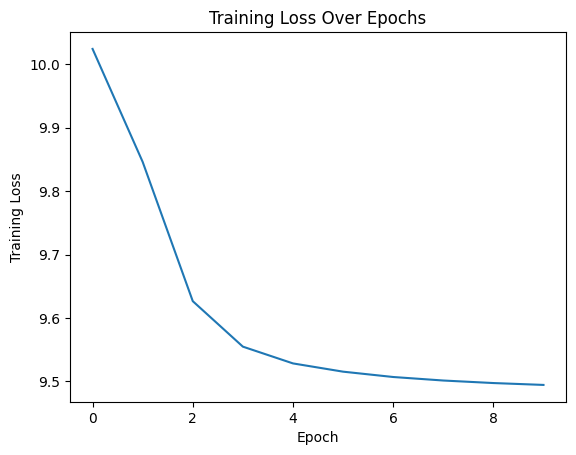

In [11]:
# Plotting the loss graph
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [17]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")



Test Accuracy: 0.008186283427323995


# Model 2:Bidirectional LSTM 

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import BertTokenizer

In [10]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, sentiments, labels, tokenizer, max_len):
        self.texts = texts
        self.sentiments = sentiments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment = str(self.sentiments[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'sentiment': sentiment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [11]:
# Define your Bidirectional LSTM with attention model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, mask):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Attention mechanism
        attn_weights = torch.tanh(self.attention(lstm_out)).squeeze(-1)
        attn_weights = torch.softmax(attn_weights.masked_fill(mask == 0, -1e9), dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        
        out = self.fc(context)
        return out

In [12]:
# Load the dataset from CSV
df = pd.read_csv('Data.csv')

# Assuming the CSV file has 'text', 'sentiment', and 'selected_text' columns
texts = df['text'].values
sentiments = df['sentiment'].values
labels = df['selected_text'].values

# Tokenize and encode the texts using a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 100  # maximum sequence length

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create DataLoader for train and test sets
train_dataset = CustomDataset(X_train, sentiments, y_train, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(X_test, sentiments, y_test, tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:

# Initialize the BiLSTM with attention model
input_dim = tokenizer.vocab_size
hidden_dim = 128
output_dim = len(label_encoder.classes_)
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Epoch 1/10:   0%|                                                                              | 0/687 [00:00<?, ?it/s]C:\Users\Administrator\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:10<00:00,  5.25it/s]


Epoch 1/10, Loss: 10.02235880411695


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:14<00:00,  5.09it/s]


Epoch 2/10, Loss: 9.757487223484977


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:16<00:00,  5.02it/s]


Epoch 3/10, Loss: 9.342551241101482


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:23<00:00,  4.78it/s]


Epoch 4/10, Loss: 8.994635774926154


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:21<00:00,  4.84it/s]


Epoch 5/10, Loss: 8.604107908806947


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:19<00:00,  4.91it/s]


Epoch 6/10, Loss: 8.190088467132924


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:19<00:00,  4.92it/s]


Epoch 7/10, Loss: 7.790470664678182


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:40<00:00,  4.27it/s]


Epoch 8/10, Loss: 7.409201424194736


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:24<00:00,  4.77it/s]


Epoch 9/10, Loss: 7.047052419515329


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 687/687 [02:19<00:00,  4.94it/s]


Epoch 10/10, Loss: 6.698501164215621


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 172/172 [00:07<00:00, 21.87it/s]

Test Accuracy: 0.03547389485173731


# GRU Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, sentiments, labels, tokenizer, max_len):
        self.texts = texts
        self.sentiments = sentiments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment = str(self.sentiments[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'sentiment': sentiment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [21]:

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Use the last hidden state
        return out

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(gru_out[:, -1, :])  # Use the last hidden state
        return out

In [22]:




# Load the dataset from CSV
df = pd.read_csv('Data.csv')

# Assuming the CSV file has 'textID', 'text', 'selected_text', and 'sentiment' columns
texts = df['text'].values
sentiments = df['sentiment'].values
labels = df['selected_text'].values

# Tokenize and encode the texts using a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 100  # maximum sequence length

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create DataLoader for train and test sets for LSTM model
train_dataset_lstm = CustomDataset(X_train, sentiments, y_train, tokenizer, max_len)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)

test_dataset_lstm = CustomDataset(X_test, sentiments, y_test, tokenizer, max_len)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=32, shuffle=False)

# Create DataLoader for train and test sets for GRU model
train_dataset_gru = CustomDataset(X_train, sentiments, y_train, tokenizer, max_len)
train_loader_gru = DataLoader(train_dataset_gru, batch_size=32, shuffle=True)

test_dataset_gru = CustomDataset(X_test, sentiments, y_test, tokenizer, max_len)
test_loader_gru = DataLoader(test_dataset_gru, batch_size=32, shuffle=False)

# Initialize the LSTM model
input_dim = len(tokenizer)
hidden_dim = 128
output_dim = len(label_encoder.classes_)
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer for LSTM model
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-4)

# Training loop for LSTM model
num_epochs = 10
train_losses_lstm = []  # to store training losses for LSTM

for epoch in range(num_epochs):
    lstm_model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader_lstm, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer_lstm.zero_grad()

        outputs = lstm_model(input_ids)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_lstm)
    train_losses_lstm.append(epoch_loss)  # save the loss for plotting
    print(f"LSTM - Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

# Initialize the GRU model
gru_model = GRUModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer for GRU model
criterion_gru = nn.CrossEntropyLoss()
optimizer_gru = optim.Adam(gru_model.parameters(), lr=1e-4)

# Training loop for GRU model
train_losses_gru = []  # to store training losses for GRU

for epoch in range(num_epochs):
    gru_model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader_gru, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer_gru.zero_grad()

        outputs = gru_model(input_ids)
        loss = criterion_gru(outputs, labels)
        loss.backward()
        optimizer_gru.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_gru)
    train_losses_gru.append(epoch_loss)  # save the loss for plotting
    print(f"GRU - Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")



Epoch 1/10:   0%|                                                                              | 0/687 [00:00<?, ?it/s]C:\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [03:24<00:00,  3.36it/s]


LSTM - Epoch 1/10, Loss: 10.027642762296585


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:54<00:00,  3.95it/s]


LSTM - Epoch 2/10, Loss: 9.846711078238453


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:44<00:00,  4.18it/s]


LSTM - Epoch 3/10, Loss: 9.625585519937795


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:44<00:00,  4.19it/s]


LSTM - Epoch 4/10, Loss: 9.550816655332518


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:44<00:00,  4.19it/s]


LSTM - Epoch 5/10, Loss: 9.52572439157633


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:50<00:00,  4.02it/s]


LSTM - Epoch 6/10, Loss: 9.512873674584268


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:47<00:00,  4.11it/s]


LSTM - Epoch 7/10, Loss: 9.5052456251919


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:45<00:00,  4.16it/s]


LSTM - Epoch 8/10, Loss: 9.499911412401492


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:48<00:00,  4.08it/s]


LSTM - Epoch 9/10, Loss: 9.49617529123631


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 687/687 [02:44<00:00,  4.18it/s]


LSTM - Epoch 10/10, Loss: 9.493204909467627


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:50<00:00,  4.04it/s]


GRU - Epoch 1/10, Loss: 10.034151646421119


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [03:00<00:00,  3.81it/s]


GRU - Epoch 2/10, Loss: 9.839158947984899


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:58<00:00,  3.84it/s]


GRU - Epoch 3/10, Loss: 9.622155790592732


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [02:56<00:00,  3.89it/s]


GRU - Epoch 4/10, Loss: 9.555378676501945


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [03:48<00:00,  3.00it/s]


GRU - Epoch 5/10, Loss: 9.531389196193201


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [04:21<00:00,  2.63it/s]


GRU - Epoch 6/10, Loss: 9.51916188374704


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [03:52<00:00,  2.95it/s]


GRU - Epoch 7/10, Loss: 9.510801945537805


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [03:26<00:00,  3.32it/s]


GRU - Epoch 8/10, Loss: 9.503157697563783


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [03:15<00:00,  3.52it/s]


GRU - Epoch 9/10, Loss: 9.49546468587595


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 687/687 [03:17<00:00,  3.48it/s]

GRU - Epoch 10/10, Loss: 9.485001675079657


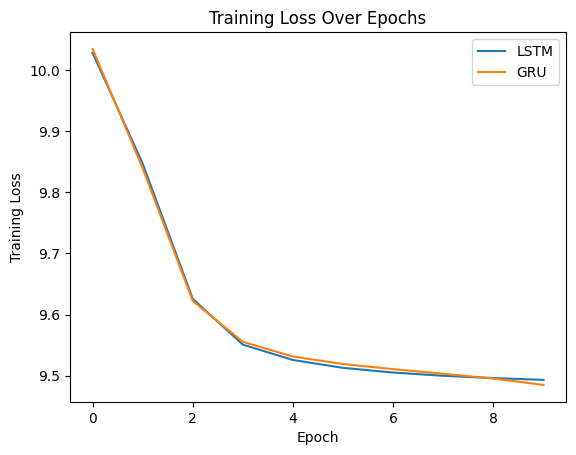

In [23]:

# Plotting the loss graph for LSTM model
plt.plot(train_losses_lstm, label='LSTM')
plt.plot(train_losses_gru, label='GRU')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [24]:

# Evaluation for LSTM model
lstm_model.eval()
all_preds_lstm = []
all_labels_lstm = []
with torch.no_grad():
    for batch in tqdm(test_loader_lstm, desc='Evaluating LSTM'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = lstm_model(input_ids)
        preds = torch.argmax(outputs, dim=1)
        all_preds_lstm.extend(preds.cpu().numpy())
        all_labels_lstm.extend(labels.cpu().numpy())

# Calculate accuracy for LSTM model
accuracy_lstm = accuracy_score(all_labels_lstm, all_preds_lstm)
print(f"LSTM Test Accuracy: {accuracy_lstm}")


Evaluating LSTM: 100%|███████████████████████████████████████████████████████████████| 172/172 [00:09<00:00, 18.47it/s]

LSTM Test Accuracy: 0.008186283427323995


In [27]:

# Evaluation for GRU model
gru_model.eval()
all_preds_gru = []
all_labels_gru = []
with torch.no_grad():
    for batch in tqdm(test_loader_gru, desc='Evaluating GRU'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = gru_model(input_ids)
        preds = torch.argmax(outputs, dim=1)
        all_preds_gru.extend(preds.cpu().numpy())
        all_labels_gru.extend(labels.cpu().numpy())

# Calculate accuracy for GRU model
accuracy_gru = accuracy_score(all_labels_gru, all_preds_gru)
print(f"GRU Test Accuracy: {accuracy_gru}")


Evaluating GRU:   0%|                                                                          | 0/172 [00:00<?, ?it/s]C:\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Evaluating GRU: 100%|████████████████████████████████████████████████████████████████| 172/172 [00:11<00:00, 14.39it/s]

GRU Test Accuracy: 0.008186283427323995


# CNN Model 

In [28]:
import torch.nn.functional as F

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.conv1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3)
        self.fc = nn.Linear(512, output_dim)

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)  # permute for Conv1d input
        conv1_out = F.relu(self.conv1(embedded))
        conv2_out = F.relu(self.conv2(conv1_out))
        pooled = F.max_pool1d(conv2_out, conv2_out.size(2)).squeeze(2)
        out = self.fc(pooled)
        return out

# Initialize the CNN model
cnn_model = CNNModel(input_dim, output_dim)

# Define loss function and optimizer for CNN model
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-4)

# Training loop for CNN model
train_losses_cnn = []  # to store training losses for CNN

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader_lstm, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer_cnn.zero_grad()

        outputs = cnn_model(input_ids)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_lstm)
    train_losses_cnn.append(epoch_loss)  # save the loss for plotting
    print(f"CNN - Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")



Epoch 1/10:   0%|                                                                              | 0/687 [00:00<?, ?it/s]C:\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [05:06<00:00,  2.24it/s]


CNN - Epoch 1/10, Loss: 10.021747984740411


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [05:59<00:00,  1.91it/s]


CNN - Epoch 2/10, Loss: 9.553312459887376


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [05:29<00:00,  2.08it/s]


CNN - Epoch 3/10, Loss: 8.87436743768195


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [06:46<00:00,  1.69it/s]


CNN - Epoch 4/10, Loss: 8.098191423013567


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [06:49<00:00,  1.68it/s]


CNN - Epoch 5/10, Loss: 6.931935364502486


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [06:32<00:00,  1.75it/s]


CNN - Epoch 6/10, Loss: 4.782353149230824


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [06:57<00:00,  1.64it/s]


CNN - Epoch 7/10, Loss: 2.111747895873096


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [06:30<00:00,  1.76it/s]


CNN - Epoch 8/10, Loss: 0.7724208865840709


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 687/687 [06:09<00:00,  1.86it/s]


CNN - Epoch 9/10, Loss: 0.3248207261826534


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 687/687 [06:39<00:00,  1.72it/s]

CNN - Epoch 10/10, Loss: 0.17865584677917642


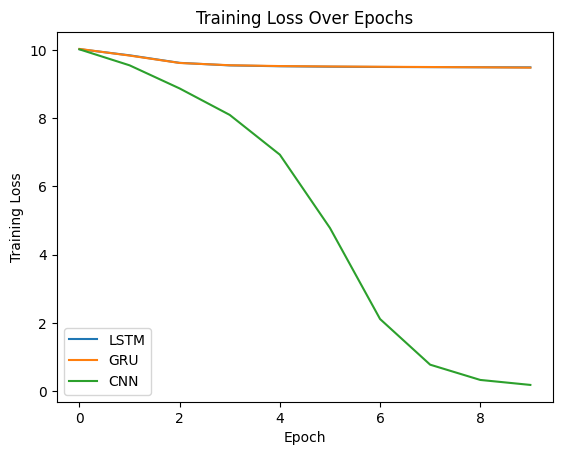

In [29]:
# Plotting the loss graph for CNN model
plt.plot(train_losses_lstm, label='LSTM')
plt.plot(train_losses_gru, label='GRU')
plt.plot(train_losses_cnn, label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()



In [31]:
# Evaluation for CNN model
cnn_model.eval()
all_preds_cnn = []
all_labels_cnn = []
with torch.no_grad():
    for batch in tqdm(test_loader_lstm, desc='Evaluating CNN'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = cnn_model(input_ids)
        preds = torch.argmax(outputs, dim=1)
        all_preds_cnn.extend(preds.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

# Calculate accuracy for CNN model
accuracy_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"CNN Test Accuracy: {accuracy_cnn}")



Evaluating CNN:   0%|                                                                          | 0/172 [00:00<?, ?it/s]C:\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Evaluating CNN: 100%|████████████████████████████████████████████████████████████████| 172/172 [00:19<00:00,  8.67it/s]

CNN Test Accuracy: 0.05275604875386575


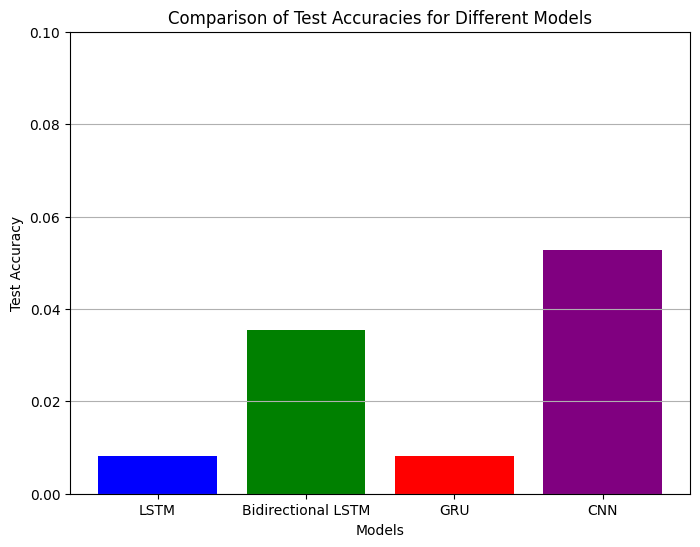

In [33]:
import matplotlib.pyplot as plt

# Model names and corresponding test accuracies
models = ['LSTM', 'Bidirectional LSTM', 'GRU', 'CNN']
test_accuracies = [0.0082, 0.0355, 0.0082, 0.0528]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies for Different Models')
plt.ylim(0, 0.1)  # Set the y-axis limit for better visualization
plt.grid(axis='y')

# Display the plot
plt.show()


# Deployment

In [38]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to perform sentiment analysis (replace with your actual sentiment analysis code)
def analyze_sentiment(text):
    # Placeholder sentiment analysis
    sentiment = "Positive" if len(text.split()) > 5 else "Neutral"
    return sentiment

# Text input widget
text_input = widgets.Textarea(
    value='',
    placeholder='Enter your review here...',
    description='Review:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='200px')  # Increase widget size
)

# Button widget to trigger analysis
analyze_button = widgets.Button(
    description='Analyze',
    disabled=False,
    button_style='info',
    tooltip='Click to analyze sentiment',
    icon=''
)

# Button widget to clear text
clear_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='warning',
    tooltip='Clear the text',
    icon=''
)

# Button widget to exit
exit_button = widgets.Button(
    description='Exit',
    disabled=False,
    button_style='danger',
    tooltip='Exit',
    icon=''
)

# Output widget to display analysis result
output = widgets.Output()

# Function to handle analyze button click event
def on_analyze_button_clicked(b):
    with output:
        output.clear_output()
        sentiment = analyze_sentiment(text_input.value)
        print(f"Sentiment: {sentiment}")

# Function to handle clear button click event
def on_clear_button_clicked(b):
    text_input.value = ''

# Function to handle exit button click event
def on_exit_button_clicked(b):
    clear_output()

# Attach click event handlers to the buttons
analyze_button.on_click(on_analyze_button_clicked)
clear_button.on_click(on_clear_button_clicked)
exit_button.on_click(on_exit_button_clicked)

# Display widgets
display(widgets.VBox([text_input, widgets.HBox([analyze_button, clear_button, exit_button]), output]))
